# Time Series Machine Learning - Sheet 1
22/03/2024

Autors:
- Jesus David Mora Venegas
- Nicolay Agustin Cerda Cortez

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy
import random
import statistics
from scipy import interpolate
import os


# Exercise 1
## Exercise 1.1
1. Write a function `flatten_relative_and_full_ts_df(df)` that takes a dataframe, in which rows are subjects/instances, columns are features, and each cell is a sorted iterable (list, numpy array, Series). The output is a dataframe with a column for the subject (this can be just some integer, e.g, what previously used to be the index), one for the timestamp, and one other for each sensor.
This function assumes (and indicates in its name) that the time series objects are com- plete in the sense that even if a piece of information is missing, then this is indicated through a np.nan. Since the lists describing the time series have no timestamp yet, this timestamp is inferred implicitly from the observations’ index in the list.

In [35]:
df = pd.read_csv('db/ieeeppg.csv', delimiter=';').iloc[:1000]

In [36]:
def flatten_relative_and_full_ts_df(df):
    new_data = []
    for c in df:
        try:
            df[c] = df[c].apply(json.loads)
        except:
            print(f"The col {c} is allready a list.")
    for row_index, col in df.iterrows():
        for sensor, values in col.items():
            for timestamp, value in enumerate(values):
                if value == None:
                    value = np.nan
                new_data.append({
                    'subject': row_index,
                    'timestamp': timestamp,
                    'sensor': sensor,
                    'value': value
                })

    df_flatten = pd.DataFrame(new_data).pivot_table(index=['subject', 'timestamp'], columns='sensor', values='value').reset_index()
    return df_flatten
test = flatten_relative_and_full_ts_df(df)

In [37]:
test

sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.0,4.0,-0.0702,0.3432,0.9594
1,0,1,NaN,6.0,-0.0702,0.3588,0.9438
2,0,2,-26.5,3.0,-0.0546,0.3666,0.9360
3,0,3,-27.0,3.5,-0.0468,0.3666,0.9360
4,0,4,-30.0,0.0,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
999995,999,995,-184.0,-103.0,-1.9734,2.4804,0.8268
999996,999,996,-191.5,-89.0,-1.8018,2.4804,0.6942
999997,999,997,-195.0,-70.5,-1.6770,2.3478,0.5694
999998,999,998,-195.0,-48.5,-1.6380,2.1450,0.4914


## Exercise 1.2
2. Write a function `insert_times(df, timestamps, sub_col="x", time_col="timestamp")`
that generates, for each subject, all timestamps according to the time scheme defined in `timestamps`, which is a list or Series, and inserts respective rows into (a copy of) `df` with `np.nan` values for all datapoints.
This function assumes that `df` is in the flattened format. `sub_col` and `time_col` simply indicate the names of the columns that contain the subjects and the timestamps, respectively.

In [38]:
test['subject'].value_counts()

subject
0      1000
671    1000
658    1000
659    1000
660    1000
       ... 
338    1000
339    1000
340    1000
341    1000
999    1000
Name: count, Length: 1000, dtype: int64

In [39]:
def insert_times(df, timestamps, sub_col="x", time_col="timestamp"):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # If timestamps is a list, convert it to a Series
    if isinstance(timestamps, list):
        timestamps = pd.Series(timestamps)

    # Get unique subjects from the dataframe
    unique_subjects = df_copy[sub_col].unique()
    
    # Iterate over each subject
    for subject in unique_subjects:
        # Get the rows for the current subject
        subject_rows = df_copy[df_copy[sub_col] == subject]
        
        # Generate the missing timestamps for the subject
        missing_timestamps = timestamps[~timestamps.isin(subject_rows[time_col])]
        
        # Create new rows with np.nan values for the missing timestamps
        new_rows = pd.DataFrame({sub_col: subject, time_col: missing_timestamps})
        new_rows = new_rows.reindex(columns=df_copy.columns)
        
        # Append the new rows to the dataframe
        df_copy = pd.concat([df_copy, new_rows], ignore_index=True)
    
    return df_copy


Define timestamps

In [40]:
# # ACTIVAR ESTE SI QUEREMOS UN TIMESTAMP DE FECHAS

# time1=pd.to_datetime('2020-01-01 00:00:00')
# time2 =time1 + pd.Timedelta(seconds=999)

# # Generate the timestamps list using the defined time scheme
# timestamps = pd.date_range(start=time1, end=time2, freq='s').strftime('%Y-%m-%d %H:%M:%S').tolist()


In [41]:
timestamps=list(range(0,1200))

In [42]:
len(timestamps)

1200

In [43]:
#Ejecutar la función
df_copy = insert_times(test, timestamps, sub_col="subject", time_col="timestamp")

In [44]:
df_copy

sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.0,4.0,-0.0702,0.3432,0.9594
1,0,1,NaN,6.0,-0.0702,0.3588,0.9438
2,0,2,-26.5,3.0,-0.0546,0.3666,0.9360
3,0,3,-27.0,3.5,-0.0468,0.3666,0.9360
4,0,4,-30.0,0.0,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
1199995,999,1195,NaN,NaN,NaN,NaN,NaN
1199996,999,1196,NaN,NaN,NaN,NaN,NaN
1199997,999,1197,NaN,NaN,NaN,NaN,NaN
1199998,999,1198,NaN,NaN,NaN,NaN,NaN


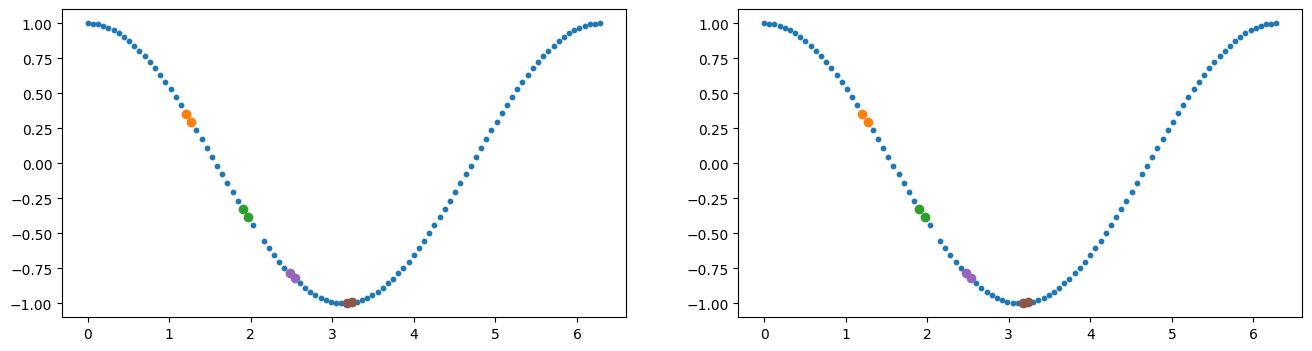

In [45]:
# average, linear, cubic, barycentric
fig,axs = plt.subplots(1,2,figsize=(16,4))
# x = df_copy.loc[df_copy['subject'] == 0]
# y = x['timestamp']

# axs[0].scatter(x['PPG1'],y)
data_x = np.linspace(0,2*np.pi,100) #TimeStamp
y = np.cos(data_x)
for n in range(5):
    y[random.randint(2,97)] = np.nan

index_nan = np.isnan(y)
num_imputation = np.count_nonzero(index_nan)
size = 10

for ax in axs:
    ax.scatter(data_x[~index_nan],y[~index_nan],s =size)
    nan_blocks = np.where(np.diff(index_nan.astype(int)))[0]
    for i in range(0, len(nan_blocks), 2):
        ax.scatter(data_x[nan_blocks[i]:nan_blocks[i+1]+1],np.interp(x=data_x[nan_blocks[i]:nan_blocks[i+1]+1],
                  xp=[data_x[nan_blocks[i]-1],data_x[nan_blocks[i+1]+1]],
                  fp=[y[nan_blocks[i]-1], y[nan_blocks[i+1]+1]]))

        

Se genera un dataframe de ejemplo para hacer validaciones:

In [46]:
data_ext = {
    'Time': np.arange(20),
    'SensorA': [1, 1.5, 2, 2.5, 3.0, 4.5, np.nan, 7.0, 8.0, 9.0, 9.5, 10.5, np.nan, np.nan, 11.0, 12.0, 13.0, np.nan, 14.0, 15.0],
    'SensorB': [2.0, 3.5, np.nan, np.nan, 4.0, 5.5, 6.0, np.nan, np.nan, 10.0, 10.5, np.nan, 11.5, 12.0, np.nan, 12.5, np.nan, 13.5, 14.0, 15.0]
}

prep_data = pd.DataFrame(data_ext)
prep_data

,Time,SensorA,SensorB
0,0,1.0,2.0
1,1,1.5,3.5
2,2,2.0,NaN
3,3,2.5,NaN
4,4,3.0,4.0
5,5,4.5,5.5
6,6,NaN,6.0
7,7,7.0,NaN
8,8,8.0,NaN
9,9,9.0,10.0


## Exercise 1.3
3. Write a function ``impute(df, technique, reach=2, lookahead=False, sub_col="x", time_col="timestamp")`` hat creates a copy of df in which all missing values have been imputed. technique is a string with the following possible values: average, linear, cubic, barycentric. reach defines how many values are included for the computation, and lookahead whether only past data or also future values should be used. If lookahead is true, then split the values in reach so that half of the points are prior to the imputed and half are posterior to the imputed times (1 more point from the past if reach is odd). You can simulate forward fill via reach = 1 and technique=average.  

- *Hint 1: Operate by subject and sensor. For each such combination, first find all indices with missing values and group them into blocks (use the helper function). Based on the indices of the blocks, you can find the indices of usable data. Observe that all imputation functions are based on x- and y-values of data that you do have. So it could be a good idea to create too lists (or a dataframe) with these pieces of information, independently of which imputation technique is being used.*

- *Hint 2: If lookahead is false and technique ∈{linear, cubic, barycentric}, then you must do an extrapolation (instead of interpolation), and this cannot be done with np.interp. You might want to check np.polyfit to solve this problem for the linear case. Generally, for the other methods check scipy.interpolate package, which has objects that allow for both interpolation and extrapolation.*


In [47]:
def impute(df, technique='average', reach=2, lookahead=False, sub_col="subject", time_col="timestamp"):
    df_copy = df.copy()
    for col in df_copy.columns:
        if col not in (sub_col, time_col):
            nan_indexes = np.where(np.isnan(df_copy[col]))[0]
            nan_blocks = np.split(nan_indexes, np.where(np.diff(nan_indexes) != 1)[0]+1)
            if len(nan_blocks[0])>0:
                for block in nan_blocks:
                    first_nan, last_nan =block[0], block[-1]
                    if lookahead:
                        lim_inf = max(0, first_nan-(reach//2))
                        lim_sup = min(len(df_copy[col])-1, last_nan+(reach//2)+1)
                    else:
                        lim_inf = max(0, first_nan - reach)
                        lim_sup = last_nan + 1
        
                    valid_indx = ~np.isnan(df_copy[col][lim_inf:lim_sup].values)
                    x_vals = np.arange(lim_inf, lim_sup)[valid_indx]
                    y_vals = df_copy[col][lim_inf:lim_sup].values[valid_indx]
 
                    if technique == 'average':
                        df_copy.loc[block, col] = np.nanmean(y_vals)
                    else:
                        if lookahead:
                            if len(x_vals) > 2 and len(y_vals) > 2:
                                if technique == 'barycentric':
                                    interp_func = scipy.interpolate.BarycentricInterpolator(x_vals, y_vals)
                                else:
                                    interp_func = interpolate.interp1d(x_vals, y_vals, kind=technique, fill_value=None, bounds_error=False)
                                df_copy.loc[block, col] = interp_func(block)
                        else:
                            if len(x_vals) > 2 and len(y_vals) > 2:
                                if technique == 'barycentric':
                                    interp_func = scipy.interpolate.BarycentricInterpolator(x_vals, y_vals)
                                if technique == 'cubic':
                                    interp_func = interpolate.interp1d(x_vals, y_vals, kind=technique, fill_value="extrapolate")
                                if technique == 'linear':
                                    interp_func = np.poly1d(np.polyfit(x_vals, y_vals, 1))
                                df_copy.loc[block, col] = interp_func(block)
                
                             
    return df_copy

In [48]:
impute(df_copy)

sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.00,4.00,-0.0702,0.3432,0.9594
1,0,1,-23.00,6.00,-0.0702,0.3588,0.9438
2,0,2,-26.50,3.00,-0.0546,0.3666,0.9360
3,0,3,-27.00,3.50,-0.0468,0.3666,0.9360
4,0,4,-30.00,0.00,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
1199995,999,1195,-194.75,-37.25,-1.6263,2.0124,0.4797
1199996,999,1196,-194.75,-37.25,-1.6263,2.0124,0.4797
1199997,999,1197,-194.75,-37.25,-1.6263,2.0124,0.4797
1199998,999,1198,-194.75,-37.25,-1.6263,2.0124,0.4797


In [49]:
# Example for each technique 
for b in [True,False]:
    for tipo in ['average', 'linear', 'cubic', 'barycentric']:
        print(b,tipo)
        #d = impute(df_copy.iloc[:27005],technique=tipo,reach=10000, lookahead = b)
        d = impute(prep_data, lookahead = b)
    print(tipo)

True average
True linear
True cubic
True barycentric
barycentric
False average
False linear
False cubic
False barycentric
barycentric


## Exercise 1.4
Write a function
```python
prepare_data(
df, frequency, start_time=0, end_time=None,
sub_col="x", time_col="timestamp",
imp_technique="linear", imp_reach=2, imp_lookahead=False
)
```
that does the following:  
1. it automatically detects whether the dataframe has already been flattened. Ohterwise, it does so (making sure that the subject and time columns have the given names).  
2. then it creates a series of all timestamps required by the time scheme. *Hint: You may want to check pandas.date_range to do this and to allow for very convenient values in the time scheme definition.*  
3. Perform upsampling by combining insert_times and impute, taking into account the given parameters.  
4. Then perform downsampling, simply eliminating all rows with timestamps that are not in the time scheme.  

Return the dataframe created in this way


#### ¿Cuándo un dataframe está *flattened*?
Se considera flattened cuando todas las columnas del dataframe son numéricas, es decir, sus .dtype no tienen listas ni objetos.

In [50]:
# Función para identificar si es flatt
def is_flattened(df):
    return all(df[col].dtype.kind in ['i', 'f'] for col in df.columns)

print(f"El dataframe original: {is_flattened(df)}")
print(f"El dataframse despues de la función de flatten: {is_flattened(test)}")


El dataframe original: False
El dataframse despues de la función de flatten: True


##### Definición de la función `prepare_data`

In [51]:
def prepare_data(df, frequency, start_time=0, end_time=None, sub_col="x", time_col="timestamp", imp_technique="linear", imp_reach=2, imp_lookahead=False):
   # Check if the dataframe is already flattened
   if is_flattened(df):
      print("The dataframe is already flattened.")
      flattened_df = df.copy()
   else: 
      print("The dataframe is not flattened.")
      print("flattening the dataframe...")
      flattened_df = flatten_relative_and_full_ts_df(df)
      print("Dataframe flattened successfully.")
   
   # Generate the timestamps list using the defined time scheme  
   timestamps = list(range(start_time, end_time, frequency))
   
   print("Starting upsampling...")
   # UPSAMPLING
   # Insert the timestamps into the dataframe
   df_up = insert_times(flattened_df, timestamps, sub_col, time_col)
   
   # Impute the missing values in the dataframe
   imputed_df = impute(df_up)
   impute(df_up, technique=imp_technique, reach=2, lookahead=False, sub_col="subject", time_col="timestamp")

   print("Starting downsampling...")
   # DOWNSAMPLING
   # Downsample the dataframe eliminating rows not in time scheme (start_time, end_time)
   downsampled_df = imputed_df[(imputed_df[time_col] >= start_time) & (imputed_df[time_col] <= end_time)]
   print("Upsampling and downsampling completed successfully.")
   
   return downsampled_df


Ejemplo aplicado:

In [53]:
prepare_data(df,frequency=1, start_time=0, end_time=150, imp_technique='average', sub_col="subject", time_col="timestamp")

The dataframe is not flattened.
flattening the dataframe...
The col PPG1 is allready a list.
The col PPG2 is allready a list.
The col x-accelerometer is allready a list.
The col y-accelerometer is allready a list.
The col z-accelerometer is allready a list.
Dataframe flattened successfully.
Starting upsampling...
Starting downsampling...
Upsampling and downsampling completed successfully.


sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.0,4.0,-0.0702,0.3432,0.9594
1,0,1,-23.0,6.0,-0.0702,0.3588,0.9438
2,0,2,-26.5,3.0,-0.0546,0.3666,0.9360
3,0,3,-27.0,3.5,-0.0468,0.3666,0.9360
4,0,4,-30.0,0.0,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
999146,999,146,73.5,44.0,0.2418,0.4524,-1.1544
999147,999,147,74.5,52.0,0.2184,0.4290,-1.1622
999148,999,148,74.0,56.0,0.1872,0.3822,-1.1466
999149,999,149,74.0,60.0,0.1326,0.3432,-1.0764


# Exercise 2
## 1. SEMG Dataset
- Read in the data data and create a non-flattened dataframe of 22 rows (11 abnormal and 11 normal subjects), each of which is one subject, with 5 columns (we only look at the data where subjects were standing), and list entries for each cell.

In [54]:
abnormal_folder = 'db/SEMG_DB1/A_TXT'
normal_folder = 'db/SEMG_DB1/N_TXT'

abnormal_files = os.listdir(abnormal_folder)
normal_files = os.listdir(normal_folder)
archivos=abnormal_files+normal_files

abnormal_paths = [os.path.join(abnormal_folder, file) for file in abnormal_files]
normal_paths = [os.path.join(normal_folder, file) for file in normal_files]

all_paths = abnormal_paths + normal_paths


# Crear un DataFrame vacío

df3=pd.DataFrame()

# Lista para almacenar los dataframes
dataframes=[]
for i,archivo in enumerate(archivos):
    if archivo.find('pie') != -1:
        df = pd.read_csv(all_paths[i], delimiter='\t', skiprows=7,usecols=range(5))
        df.columns=['1','2','3','4','5']

        df_final = pd.DataFrame()

        # Iterar sobre cada columna del DataFrame original
        for columna in df.columns:
            # Convertir la columna actual en una lista y agregarla como una fila al DataFrame final
            df_final[columna] = [df[columna].tolist()]
        
        df3=pd.concat([df3,df_final],ignore_index=True)

df3

,1,2,3,4,5
0,"[0.0375, 0.0637, 0.0667, 0.0427, 0.0262, 0.012...","[0.009, 0.012, 0.0127, 0.0105, 0.0075, 0.0052,...","[0.0105, 0.0232, 0.0352, 0.027, -0.0015, -0.03...","[0.0142, 0.0165, 0.0172, 0.015, 0.0127, 0.009,...","[1.1, 1.0, 1.1, 0.9, 1.1, 1.2, 0.9, 1.0, 0.8, ..."
1,"[-0.0098, -0.0105, -0.0105, -0.0083, -0.0068, ...","[0.0007, 0.0007, 0.0022, -0.0015, -0.0038, -0....","[0.0052, 0.003, 0.0037, 0.0052, 0.0052, 0.0067...","[-0.0015, -0.012, 0.0015, 0.0225, 0.0202, 0.02...","[3.5, 3.2, 3.3, 3.2, 3.5, 3.2, 3.2, 3.4, 3.2, ..."
2,"[0.0045, 0.0037, 0.0015, -0.0008, -0.0015, -0....","[0.0232, 0.0682, 0.0202, -0.0593, -0.0008, 0.0...","[-0.0128, -0.0143, -0.012, -0.0075, -0.0008, 0...","[-0.048, -0.057, -0.0368, -0.0473, -0.0083, -0...","[94.3, 94.3, 94.5, 94.3, 94.4, 94.6, 94.1, 94...."
3,"[0.0037, 0.0015, 0.0007, 0.0015, 0.0022, 0.003...","[-0.0046, -0.0023, 0.0, 0.0007, -0.0008, 0.000...","[-0.0008, -0.0008, -0.0015, -0.0015, 0.0007, 0...","[0.0007, 0.0, -0.0015, -0.0046, -0.0046, -0.00...","[0.9, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.8, ..."
4,"[-0.003, -0.0015, -0.0008, -0.0008, 0.0007, 0....","[0.0015, -0.0023, -0.0008, -0.0008, -0.0008, 0...","[-0.0008, -0.0008, -0.0023, -0.0023, -0.0015, ...","[-0.003, -0.0015, -0.0015, -0.0008, -0.0015, -...","[3.1, 3.2, 3.1, 3.3, 3.1, 3.0, 3.2, 3.1, 3.1, ..."
5,"[-0.0015, -0.0053, -0.0068, -0.003, 0.0, 0.0, ...","[-0.0068, -0.0458, -0.0398, -0.0368, -0.039, -...","[0.003, -0.0008, -0.0008, -0.0038, -0.003, 0.0...","[-0.0091, -0.0098, -0.0068, -0.0046, -0.0015, ...","[-4.5, -4.6, -4.6, -4.5, -4.7, -4.6, -4.6, -4...."
6,"[-0.0188, -0.024, -0.0158, 0.0127, 0.0255, 0.0...","[0.081, 0.1117, 0.075, 0.0157, 0.0052, -0.0053...","[0.0045, 0.0045, 0.0045, 0.0015, -0.0083, -0.0...","[0.0232, 0.021, 0.0105, 0.0075, 0.003, 0.0022,...","[6.1, 5.8, 5.8, 6.0, 5.8, 5.7, 6.0, 5.7, 5.8, ..."
7,"[0.0082, 0.009, 0.009, 0.0097, 0.009, 0.0067, ...","[-0.0008, 0.0007, 0.0007, -0.0008, -0.0015, -0...","[-0.0053, -0.0046, -0.0015, -0.0023, -0.0046, ...","[0.0045, 0.0052, 0.003, 0.0015, -0.0015, -0.00...","[87.9, 88.1, 87.9, 88.0, 88.0, 87.9, 88.0, 87...."
8,"[-0.0008, -0.0015, 0.0007, 0.0015, 0.0015, 0.0...","[0.024, -0.0068, -0.0105, 0.0105, 0.0277, 0.02...","[0.0, 0.0015, 0.0, 0.0, 0.0015, 0.0015, 0.0, 0...","[-0.003, -0.006, -0.006, -0.0015, 0.0007, -0.0...","[1.5, 1.3, 1.7, 1.4, 1.4, 1.8, 1.5, 1.3, 1.6, ..."
9,"[0.0, -0.0008, -0.003, -0.0015, 0.0007, -0.000...","[0.0037, 0.0045, 0.0037, 0.0022, 0.0015, 0.000...","[-0.0015, -0.0015, -0.0015, -0.0015, 0.0, -0.0...","[0.0022, 0.003, 0.0015, 0.0015, 0.0015, 0.0007...","[-0.6, -0.4, -0.6, -0.5, -0.4, -0.5, -0.5, -0...."


Estan ubicados en el siguiente orden:

In [55]:
for i,archivo in enumerate(archivos):
    if archivo.find('pie') != -1:
        print(i,archivo)

1 6Apie.txt
6 7Apie.txt
11 5Apie.txt
15 4Apie.txt
18 8Apie.txt
21 1Apie.txt
23 9Apie.txt
25 2Apie.txt
27 11Apie.txt
30 3Apie.txt
31 10Apie.txt
35 9Npie.txt
37 8Npie.txt
39 1Npie.txt
41 3Npie.txt
43 10Npie.txt
44 2Npie.txt
45 11Npie.txt
49 7Npie.txt
52 6Npie.txt
57 4Npie.txt
65 5Npie.txt


- Create a reasonable time scheme and prepare the dataset using your above function. Is imputation being used here? Why or why not?

In [56]:
timestamps=list(range(0,16756))

In [57]:
prepare_data(df3,frequency=1, start_time=0, end_time=16756, imp_technique='average', sub_col="subject", time_col="timestamp")

The dataframe is not flattened.
flattening the dataframe...
The col 1 is allready a list.
The col 2 is allready a list.
The col 3 is allready a list.
The col 4 is allready a list.
The col 5 is allready a list.


Dataframe flattened successfully.
Starting upsampling...
Starting downsampling...
Upsampling and downsampling completed successfully.


sensor,subject,timestamp,1,2,3,4,5
0,0,0,0.0375,0.0090,0.0105,0.0142,1.1
1,0,1,0.0637,0.0120,0.0232,0.0165,1.0
2,0,2,0.0667,0.0127,0.0352,0.0172,1.1
3,0,3,0.0427,0.0105,0.0270,0.0150,0.9
4,0,4,0.0262,0.0075,-0.0015,0.0127,1.1
...,...,...,...,...,...,...,...
456130,21,16751,0.0022,0.0037,-0.0068,0.0037,4.1
456131,21,16752,0.0022,0.0037,-0.0068,0.0037,4.1
456132,21,16753,0.0022,0.0037,-0.0068,0.0037,4.1
456133,21,16754,0.0022,0.0037,-0.0068,0.0037,4.1


#### Answer to *Is imputation used? Why?
Sí, se usa imputación debido a que las bases de datos contienen diferentes cantidades de registros. Es decir, en unas bases de datos hay más filas que en otras, al momento de aplanar (*flatten*) el dataframe aplicando el *time scheme* se generan varios vacíos debido a estas diferencias en la cantidad de registros. Por esta razón, para eliminar los NaN se debe utilizar imputación.

- Visualize the full dataset by creating five figures, one for each feature, in each of
which you show the 22 curves of the subjects

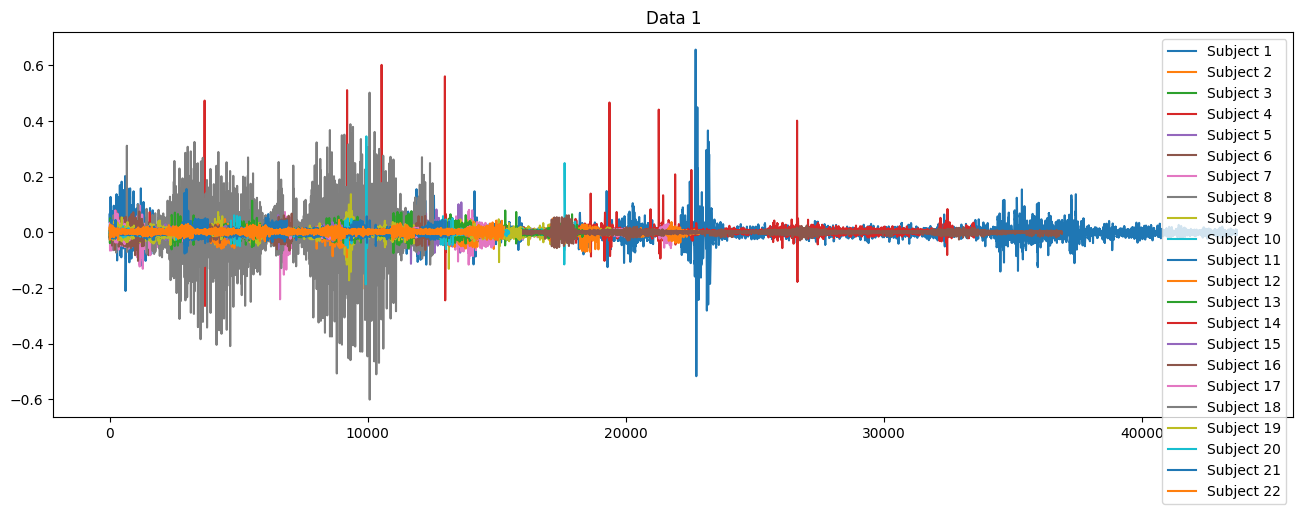

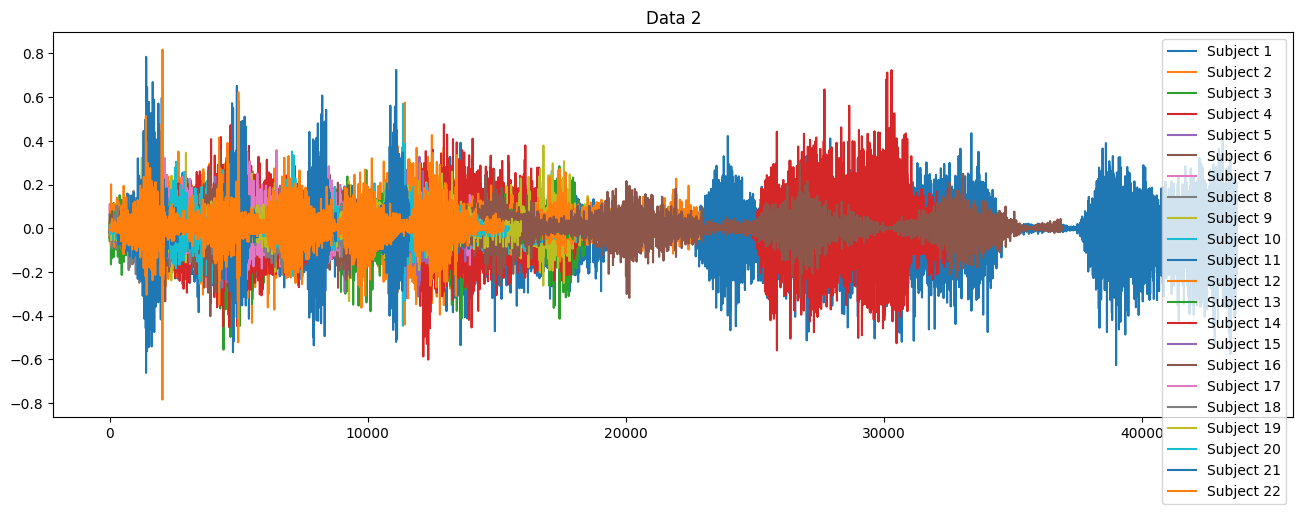

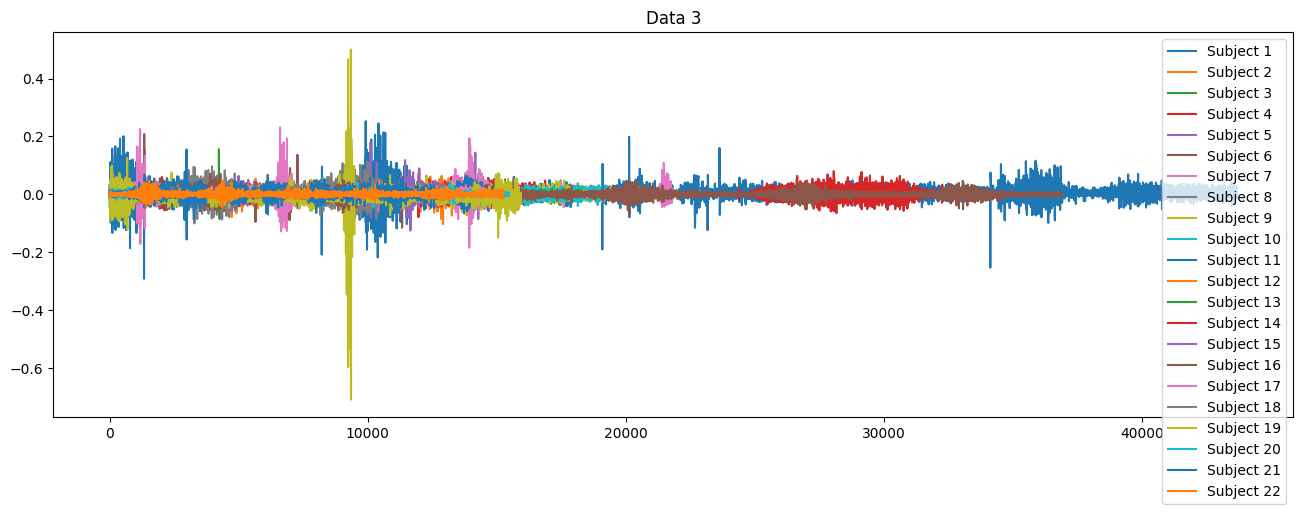

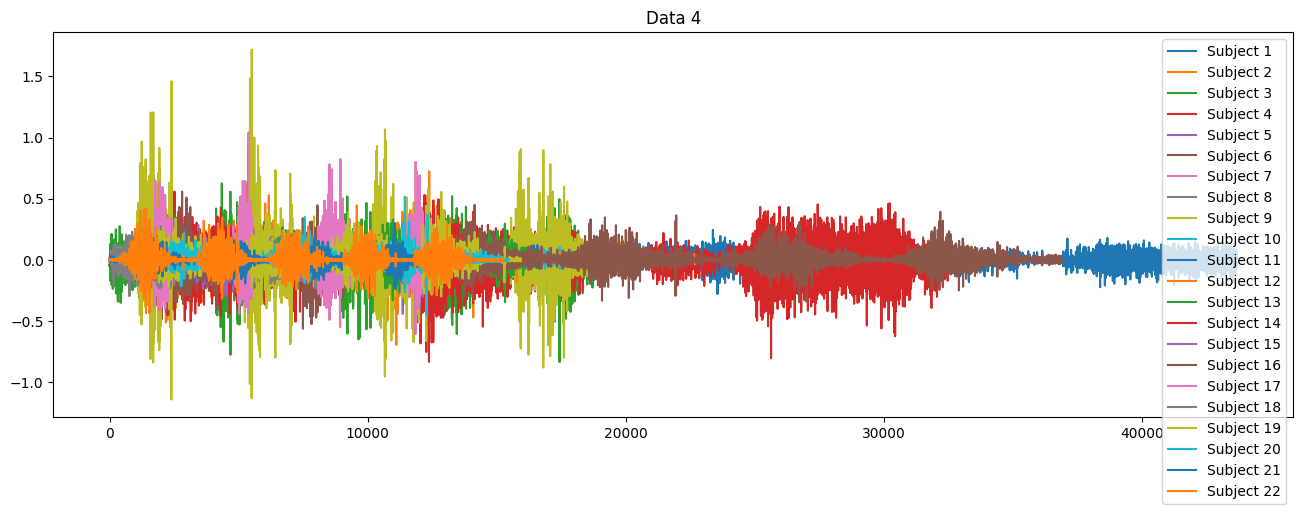

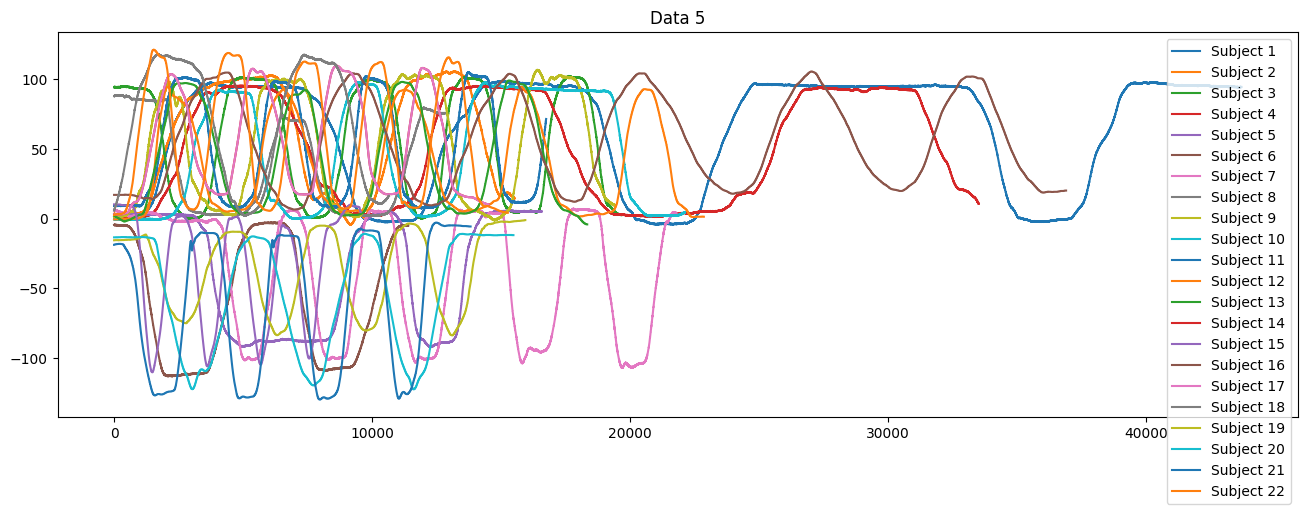

In [58]:
for i in df3.columns:
    fig, ax = plt.subplots(figsize=(16,5))
    for j, subjectx in enumerate(df3[i][:22]):
        ax.plot(subjectx, label=f"Subject {j+1}")

    ax.set_title(f'Data {i}')
    ax.legend()
    plt.show()


### Si queremos ver por sujeto:

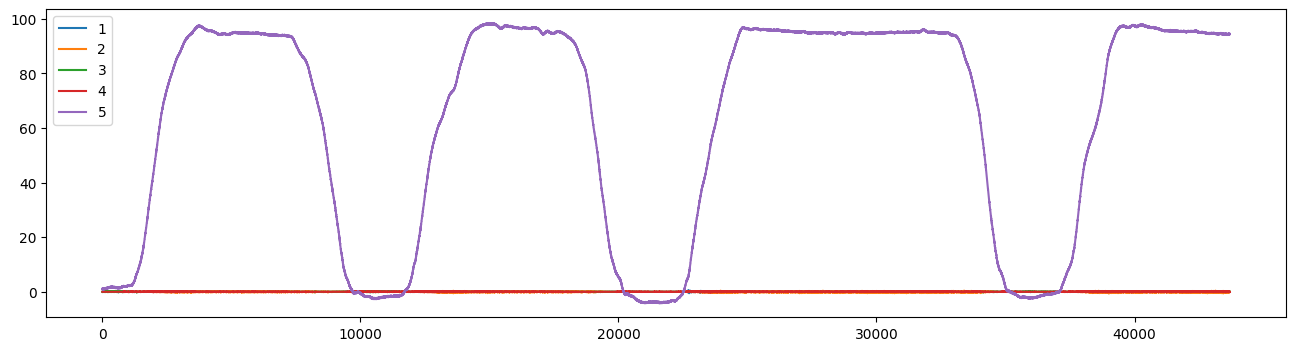

In [59]:
# Graficando para el sujeto 1
fig, ax = plt.subplots(figsize=(16,4))
subject1=df3.iloc[0] #fijamos el primer paciente
for col in df3.columns:
    ax.plot(subject1[col], label=col)
ax.legend()
plt.show()

##